## Zestaw 4

### Zadanie 1

GAN (Generative Adversarial Network) to architektura sieci głębokich, zaproponowana w 2014 roku przez Iana Goodfellowa i współautorów. Ideą GAN jest jednoczesne trenowanie dwóch modeli:

1. Generator (G)

- Zadaniem generatora jest wytwarzanie (generowanie) „próbek” przypominających dane z rozkładu uczącego (np. obrazy, punkty w 2D, dane o rozkładzie normalnym itp.).
- Generator przyjmuje na wejściu losowy wektor (tzw. noise vector), np. z rozkładu Gaussa lub z rozkładu jednorodnego, a następnie próbuje „przekształcić” ten losowy wektor w coś, co wygląda jak dane prawdziwe.

2. Dyskryminator (D)

- Zadaniem dyskryminatora jest rozróżnianie, czy dana próbka (np. obrazek) pochodzi z „prawdziwego” zbioru uczącego czy została wygenerowana przez generator.
- Dyskryminator otrzymuje na wejście zarówno prawdziwe dane (z etykietą 1 – prawdziwe) jak i fałszywe dane (z generatora, etykieta 0 – fałszywe).

3. Trening przebiega w tzw. minigrze dwugraczowej:

- Dyskryminator D stara się jak najlepiej odróżniać próbki prawdziwe od generowanych (minimalizuje błąd klasyfikacji).
- Generator G stara się „oszukać” dyskryminator, tzn. wytworzyć takie próbki, które dyskryminator zakwalifikuje jako prawdziwe.

Matematycznie pisząc, w czasie trenowania:

- Aktualizujemy D tak, aby poprawnie klasyfikował próbki (prawdziwe jako 1, fałszywe jako 0).
- Następnie aktualizujemy G tak, by zwiększyć szansę, że D uzna próbki z G za prawdziwe.

W rezultacie, przy dobrze zbalansowanym treningu:

- Dyskryminator staje się coraz lepszy w rozpoznawaniu „fake’ów”,
- Generator staje się coraz lepszy w „podrabianiu” danych (obrazów, punktów, kształtów itd.).


32/32 [==============================] - 0s 953us/step


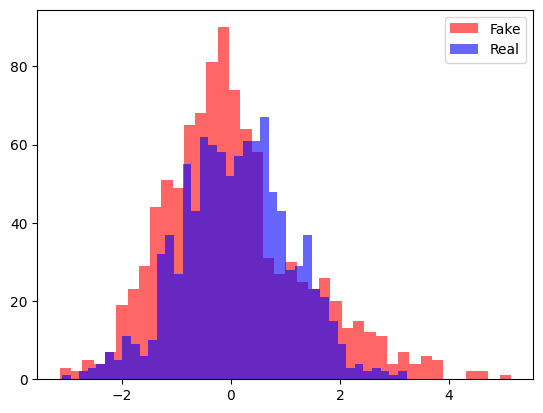

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# 1. Przygotowanie danych - docelowy rozkład (np. normalny)
def real_data_generator(batch_size):
    """
    Generuje 'batch_size' próbek z prawdziwego rozkładu (np. N(0,1)).
    """
    return np.random.normal(loc=0, scale=1, size=(batch_size, 1))

# 2. Definicja Dyskryminatora
def build_discriminator():
    model = Sequential()
    model.add(Dense(16, input_dim=1, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# 3. Definicja Generatora
def build_generator(latent_dim=2):
    """
    latent_dim to wymiar szumu (noise). Generator zamieni wektor 'noise' 
    np. 2-wymiarowy w 1-wymiarową próbkę, która powinna pochodzić z N(0,1).
    """
    model = Sequential()
    model.add(Dense(8, input_dim=latent_dim, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  # bez sigmoid, bo chcemy 1-wymiar z R
    return model

# 4. Budowa poszczególnych modeli
latent_dim = 2
D = build_discriminator()
G = build_generator(latent_dim)

# Kompilujemy dyskryminator (osobno)
D.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

# Budujemy model GAN (Generator + Dyskryminator połączone)
# Uwaga: dyskryminator zamrażamy w tym modelu, bo w trakcie trenowania G nie chcemy update'ować wag D
D.trainable = False

gan_model = Sequential([G, D])
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001))

# 5. Trenowanie
epochs = 1000
batch_size = 32
losses = []

for epoch in range(epochs):
    # --- Trenowanie Dyskryminatora ---
    # 5.1. Prawdziwe dane
    real_data = real_data_generator(batch_size)
    real_labels = np.ones((batch_size, 1))  # etykiety = 1
    
    # 5.2. Fałszywe dane
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))  # noise
    fake_data = G.predict(noise)
    fake_labels = np.zeros((batch_size, 1))  # etykiety = 0

    # 5.3. Połączenie w jeden batch i trenowanie
    X = np.concatenate([real_data, fake_data])
    y = np.concatenate([real_labels, fake_labels])

    # Odmrażamy D (na ten fragment)
    D.trainable = True
    d_loss, d_acc = D.train_on_batch(X, y)

    # --- Trenowanie Generatora ---
    # Aby trenować G, generujemy noise i chcemy, żeby D uznał je za prawdziwe (label=1)
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1))

    # Zamrażamy D
    D.trainable = False
    g_loss = gan_model.train_on_batch(noise, valid_y)

    losses.append((d_loss, g_loss))
    
    # Co pewien czas wypiszmy postęp
    if (epoch+1) % 2000 == 0:
        print(f"Epoka: {epoch+1}, D_loss: {d_loss:.4f}, G_loss: {g_loss:.4f}")

# 6. Wizualizacja wyników - sprawdźmy, jak Generator generuje próbki
num_samples = 1000
noise = np.random.normal(0, 1, size=(num_samples, latent_dim))
generated = G.predict(noise)

plt.hist(generated, bins=40, alpha=0.6, color='red', label='Fake')
real_samp = real_data_generator(num_samples)
plt.hist(real_samp, bins=40, alpha=0.6, color='blue', label='Real')
plt.legend()
plt.show()


### Zadanie 2 

4/4 [==============================] - 0s 4ms/step
Epoka 0, d_loss=0.690, g_loss=0.696
32/32 [==============================] - 0s 2ms/step


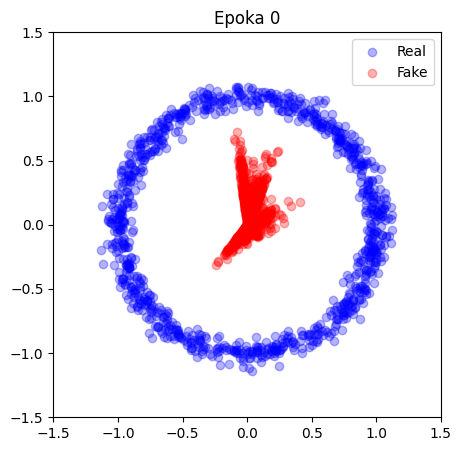

4/4 [==============================] - 0s 1ms/step
Epoka 500, d_loss=0.583, g_loss=0.869
32/32 [==============================] - 0s 1ms/step


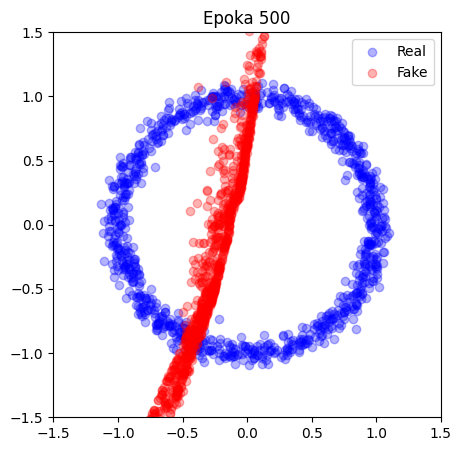

4/4 [==============================] - 0s 3ms/step
Epoka 1000, d_loss=0.672, g_loss=1.034
32/32 [==============================] - 0s 899us/step


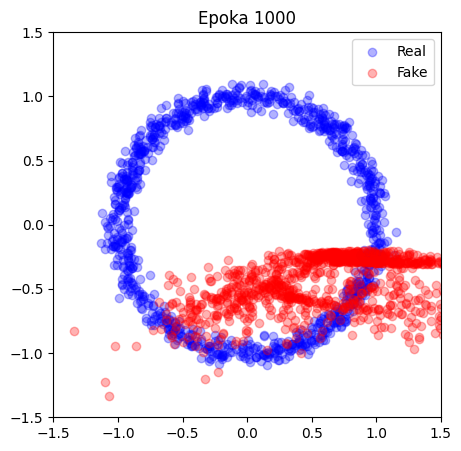

4/4 [==============================] - 0s 3ms/step
Epoka 1500, d_loss=0.431, g_loss=1.200
32/32 [==============================] - 0s 2ms/step


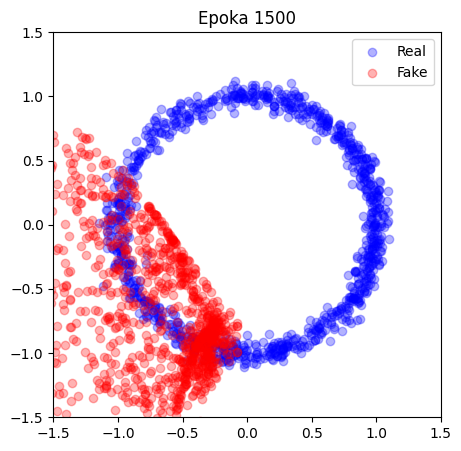

4/4 [==============================] - 0s 3ms/step
Epoka 2000, d_loss=0.732, g_loss=0.621
32/32 [==============================] - 0s 1ms/step


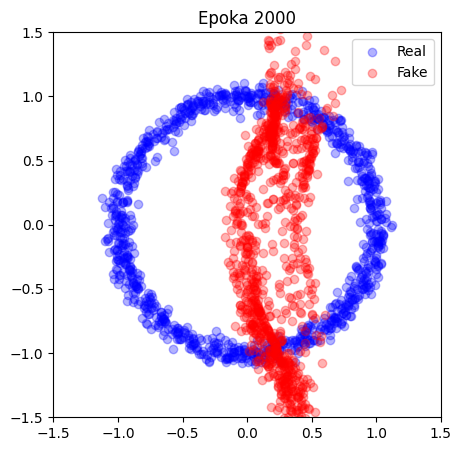

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# 1. Generator danych realnych (okrag z szumem)
def generate_real_data(batch_size, radius=1.0):
    angles = np.random.uniform(0, 2*np.pi, batch_size)
    # x = r*cos(theta), y = r*sin(theta), plus mały szum
    xs = radius * np.cos(angles) + np.random.normal(0, 0.05, batch_size)
    ys = radius * np.sin(angles) + np.random.normal(0, 0.05, batch_size)
    return np.column_stack([xs, ys])

# 2. Discriminator - input_dim=2, bo (x,y)
def build_discriminator():
    model = Sequential()
    model.add(Dense(16, input_dim=2, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# 3. Generator
def build_generator(latent_dim=2):
    model = Sequential()
    model.add(Dense(16, input_dim=latent_dim, activation='relu'))
    model.add(Dense(16, activation='relu'))
    # output_dim=2 -> generuje (x,y)
    model.add(Dense(2))
    return model

latent_dim = 2
D = build_discriminator()
D.compile(loss='binary_crossentropy', optimizer=Adam(0.001))

# Budowa modelu GAN
G = build_generator(latent_dim)
D.trainable = False
gan = Sequential([G, D])
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.001))

epochs = 2001
batch_size = 128

for epoch in range(epochs):
    # 1. TRenowanie D
    # a) dane realne
    real_data = generate_real_data(batch_size)
    real_labels = np.ones((batch_size, 1))
    
    # b) dane fake
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    fake_data = G.predict(noise)
    fake_labels = np.zeros((batch_size, 1))
    
    # c) połaczenie i trenowanie D
    X = np.concatenate([real_data, fake_data])
    y = np.concatenate([real_labels, fake_labels])
    
    D.trainable = True
    d_loss = D.train_on_batch(X, y)

    # 2. Trenowanie G
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    # chcemy aby D uznał je za real -> label=1
    valid_y = np.ones((batch_size, 1))
    D.trainable = False
    g_loss = gan.train_on_batch(noise, valid_y)

    # 3. Wizualizacja co pewną liczbę epok
    if epoch % 500 == 0:
        print(f"Epoka {epoch}, d_loss={d_loss:.3f}, g_loss={g_loss:.3f}")
        # Wygeneruj kilka danych i zrób wykres
        gen_points = G.predict(np.random.normal(0, 1, size=(1000, latent_dim)))
        real_points = generate_real_data(1000)
        
        plt.figure(figsize=(5,5))
        plt.scatter(real_points[:,0], real_points[:,1], color='blue', alpha=0.3, label='Real')
        plt.scatter(gen_points[:,0], gen_points[:,1], color='red', alpha=0.3, label='Fake')
        plt.xlim(-1.5, 1.5)
        plt.ylim(-1.5, 1.5)
        plt.legend()
        plt.title(f"Epoka {epoch}")
        plt.show()


### Zadanie 3

1/1 [==============================] - 0s 36ms/step
50 / 100 [D loss: 0.4723, acc.: 89.06%] [G loss: 0.7446]
1/1 [==============================] - 0s 108ms/step


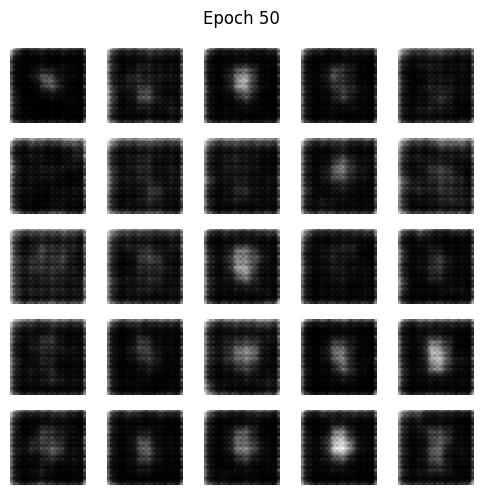

1/1 [==============================] - 0s 59ms/step
100 / 100 [D loss: 0.4956, acc.: 76.56%] [G loss: 0.7930]
1/1 [==============================] - 0s 67ms/step


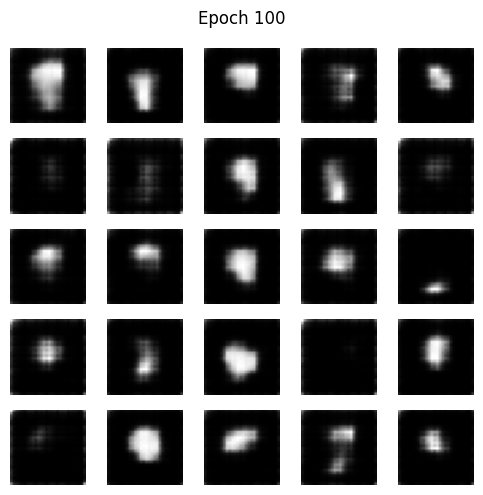

Koniec trenowania. Wizualizacja próbek z finalnie wytrenowanego generatora:
1/1 [==============================] - 0s 65ms/step


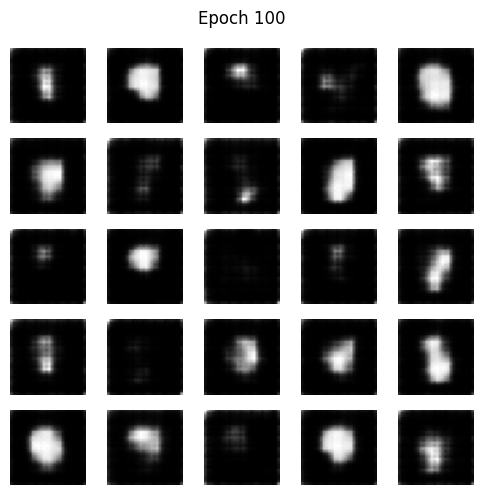

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from keras.optimizers import Adam

# 1. Ładowanie MNIST
(X_train, y_train), (_, _) = mnist.load_data()
X_train = X_train.astype('float32') / 255.0  # normalizacja [0,1]
X_train = np.expand_dims(X_train, axis=-1)  # (28,28,1)

# Parametry
img_rows, img_cols, channels = 28, 28, 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100  # Wymiar wektora szumu

# 2. Definicja Dyskryminatora
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, 
                     input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=3, strides=2, 
                     padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

# 3. Definicja Generatora
def build_generator():
    model = Sequential()
    # Start z wektora szumu
    model.add(Dense(7 * 7 * 128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))

    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, 
                              padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(32, kernel_size=3, strides=2, 
                              padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(1, kernel_size=3, padding='same', 
                     activation='sigmoid'))

    return model

# 4. Budowa i kompilacja
D = build_discriminator()
D.compile(loss='binary_crossentropy', 
          optimizer=Adam(0.0002, 0.5), 
          metrics=['accuracy'])

G = build_generator()

# GAN = Generator (G) + Dyskryminator (D)
z = Sequential([G, D])

# Zamrażamy wagi dyskryminatora w pełnym modelu
D.trainable = False
z.compile(loss='binary_crossentropy', 
          optimizer=Adam(0.0002, 0.5))
D.trainable = True

# Funkcja pomocnicza do wizualizacji wygenerowanych obrazów
def plot_generated_images(generator, epoch, examples=25, dim=(5,5), figsize=(5,5)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    gen_imgs = generator.predict(noise)

    # Reshape i skala
    gen_imgs = gen_imgs.reshape((examples, 28, 28))

    fig, axs = plt.subplots(dim[0], dim[1], figsize=figsize)
    cnt = 0
    for i in range(dim[0]):
        for j in range(dim[1]):
            axs[i,j].imshow(gen_imgs[cnt], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.suptitle(f'Epoch {epoch+1}', fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close()

# 5. Trenowanie
epochs = 500
batch_size = 64
sample_interval = 50  # zmniejszony tak, aby wyświetlać próbki częściej

half_batch = batch_size // 2

for epoch in range(epochs):
    # 1. Trenuj Dyskryminator
    # a) Pobierz losowe próbki REAL (z MNIST)
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    # b) Wygeneruj FAKE
    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    gen_imgs = G.predict(noise)

    # c) Trenuj D na real
    real_y = np.ones((half_batch, 1))
    d_loss_real = D.train_on_batch(imgs, real_y)

    # d) Trenuj D na fake
    fake_y = np.zeros((half_batch, 1))
    d_loss_fake = D.train_on_batch(gen_imgs, fake_y)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 2. Trenuj Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1))

    D.trainable = False
    g_loss = z.train_on_batch(noise, valid_y)
    D.trainable = True

    # 3. Wyświetl postęp + próbki co sample_interval
    if (epoch + 1) % sample_interval == 0:
        print(f"{epoch + 1} / {epochs} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
        plot_generated_images(G, epoch)

# Dodatkowo - wyświetlenie próbek na końcu trenowania
print("Koniec trenowania. Wizualizacja próbek z finalnie wytrenowanego generatora:")
plot_generated_images(G, epochs - 1)

### Zadanie 4

1/1 [==============================] - 0s 24ms/step
1000 [D loss: 0.6658, acc: 68.75%] [G loss: 0.8398]
1/1 [==============================] - 0s 25ms/step


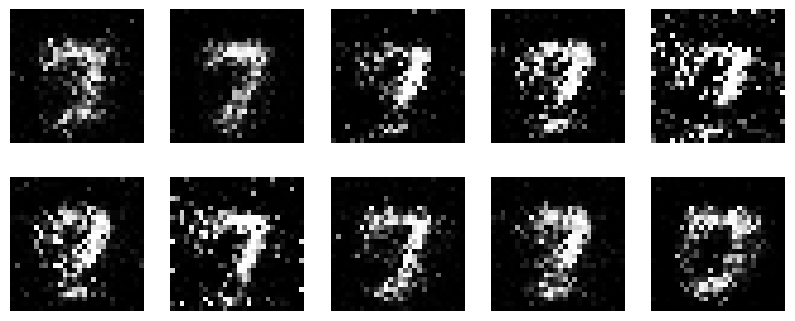

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, multiply
from keras.layers import BatchNormalization, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

# --- 1. Parametry ---
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

num_classes = 10       # liczba klas w MNIST
latent_dim = 100       # wymiar wektora szumu

# --- 2. Wczytanie i przygotowanie MNIST ---
(X_train, y_train), (_, _) = mnist.load_data()

# Normalizacja od -1 do 1 (przy tanh na wyjściu generatora)
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)  # => (28,28,1)

# Etykiety w formie (n, 1)
y_train = y_train.reshape(-1, 1)

# --- 3. Budowa Generatora ---
def build_generator():
    # Wejście: (noise, label)
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    
    # Embedding etykiety => wymiar dopasowany do latent_dim (100)
    label_embedding = Embedding(num_classes, latent_dim)(label)  
    label_embedding = Flatten()(label_embedding)  # => (batch_size, 100)
    
    # Warunkowanie przez mnożenie [noise * label_embedding]
    model_input = multiply([noise, label_embedding])
    
    x = Dense(256)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    # Wyjście: 28*28=784 neuronów + tanh (dla wartości w [-1,1])
    x = Dense(784, activation='tanh')(x)
    out = Reshape((28, 28, 1))(x)
    
    generator = Model([noise, label], out)
    return generator

# --- 4. Budowa Dyskryminatora ---
def build_discriminator():
    # Wejście: (obraz, label)
    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')
    
    # Embedding do wymiaru 784 (czyli 28*28)
    label_embedding = Embedding(num_classes, img_rows * img_cols)(label)  
    label_embedding = Flatten()(label_embedding)  # => (batch_size, 784)
    
    # Spłaszczamy obraz => (784,)
    flat_img = Flatten()(img)
    
    # Mnożenie (batch_size, 784) * (batch_size, 784)
    model_input = multiply([flat_img, label_embedding])
    
    x = Dense(512)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # 1 neuron - wyjście (prawdopodobieństwo bycia "real")
    validity = Dense(1, activation='sigmoid')(x)
    
    discriminator = Model([img, label], validity)
    return discriminator

# --- Kompilacja modeli ---
optimizer = Adam(0.0002, 0.5)

# Budowa i kompilacja dyskryminatora
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=optimizer, 
                      metrics=['accuracy'])

# Budowa generatora
generator = build_generator()

# Łączymy generator i dyskryminator w jeden model (zamrażając D w trakcie trenowania G)
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
img = generator([noise, label])

discriminator.trainable = False
valid = discriminator([img, label])
cgan = Model([noise, label], valid)
cgan.compile(loss='binary_crossentropy', optimizer=optimizer)

# --- 5. Trenowanie cGAN ---
epochs = 1000       # Liczba epok
batch_size = 32
half_batch = batch_size // 2
sample_interval = 200  # co ile epok wyświetlać przykładowe generacje

def plot_generated_images(generator, epoch, examples=10):
    """
    Funkcja pomocnicza do generowania i wyświetlania przykładowych obrazów
    dla każdej z 10 klas MNIST (0..9).
    """
    # Tworzymy siatkę 2 wierszy x 5 kolumn => 10 obrazków, po jednym na klasę
    r, c = 2, 5
    fig, axs = plt.subplots(r, c, figsize=(10, 4))
    
    # Generuj noise
    noise = np.random.normal(0, 1, (examples, latent_dim))
    # Etykiety klas (0..9)
    sampled_labels = np.array([[i] for i in range(examples)])
    
    gen_imgs = generator.predict([noise, sampled_labels])
    # Przeskalowanie z [-1,1] do [0,1]
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i,j].set_title(f"Klasa: {cnt}")
            axs[i,j].axis('off')
            cnt += 1
    fig.suptitle(f"Przykładowe obrazy po epoce {epoch+1}")
    plt.show()
    plt.close()

for epoch in range(epochs):
    # 1) Trenuj dyskryminator
    # a) Pobierz losowe obrazy REAL
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]            # (half_batch,28,28,1)
    labels = y_train[idx]          # (half_batch,1)
    
    # b) Wygeneruj obrazy FAKE
    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    gen_labels = np.random.randint(0, num_classes, (half_batch, 1))
    gen_imgs = generator.predict([noise, gen_labels])
    
    # c) Trenuj D na real i fake
    d_loss_real = discriminator.train_on_batch([imgs, labels], np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch([gen_imgs, gen_labels], np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # 2) Trenuj generator (chcemy, by D uznawał generowane za real)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    sampled_labels = np.random.randint(0, num_classes, (batch_size, 1))
    valid_y = np.ones((batch_size, 1))
    g_loss = cgan.train_on_batch([noise, sampled_labels], valid_y)
    
    # 3) Wyświetl postęp
    if (epoch + 1) % sample_interval == 0:
        print(f"{epoch + 1}/{epochs} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
        plot_generated_images(generator, epoch)

# --- 6. Wizualizacja końcowa (po treningu)
print("Trening zakończony. Wizualizacja obrazów (klasy 0..9) z finalnie wytrenowanego generatora:")
plot_generated_images(generator, epochs - 1)

### Zadanie 5

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# 1. Wczytanie danych
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# CNN wymaga kanału (channels=1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# 2. Budowa prostej sieci CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=3, validation_split=0.1)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

In [ ]:
import tensorflow as tf

def create_adversarial_pattern(model, image, label):
    """
    Zwraca perturbację znakową gradientu, by zmylić model.
    """
    # Upewnij się, że image i label mają kształty batchowe
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)
    # Oblicz gradient
    gradient = tape.gradient(loss, image)
    # Znak gradientu
    signed_grad = tf.sign(gradient)
    return signed_grad

# Przykład ataku na jeden obraz z x_test
idx = 0
sample_image = x_test[idx:idx+1]  # shape (1,28,28,1)
sample_label = y_test[idx:idx+1]

perturbation = create_adversarial_pattern(model, sample_image, sample_label)

epsilon = 0.1  # nasza skala perturbacji
adv_image = sample_image + epsilon * perturbation
adv_image = tf.clip_by_value(adv_image, 0, 1)  # przycięcie do [0,1]

# Sprawdźmy predykcje
pred_orig = model.predict(sample_image)
pred_adv = model.predict(adv_image)

print("Oryginalna etykieta:", sample_label[0])
print("Model na oryginale:", np.argmax(pred_orig[0]))
print("Model na ataku   :", np.argmax(pred_adv[0]))

# Wizualizacja
plt.subplot(1,3,1)
plt.title("Oryginalny")
plt.imshow(sample_image[0,:,:,0], cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Perturbacja")
plt.imshow((perturbation[0,:,:,0]).numpy().squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Atak (adv)")
plt.imshow(adv_image[0,:,:,0], cmap='gray')
plt.axis('off')
plt.show()

### Zadanie 6

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

text = "Hello there! This is an example sentence showing off the stop words filtration."

# 1. Tokenizacja
tokens = word_tokenize(text.lower())

# 2. Usunięcie znaków niechcianych (np. interpunkcja) – filtry proste
tokens = [t for t in tokens if t.isalpha()]

# 3. Stop words
stop_words = set(stopwords.words('english'))
tokens = [t for t in tokens if t not in stop_words]

print("Po tokenizacji i usunięciu stopwords:", tokens)

# 4. Stemming i Lemmatization
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

stems = [stemmer.stem(w) for w in tokens]
lemmas = [lemmatizer.lemmatize(w) for w in tokens]

print("Stems :", stems)
print("Lemmas:", lemmas)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

documents = [
    "I like machine learning and NLP",
    "I love deep learning for computer vision",
    "NLP is very interesting",
    "Machine learning is popular in data science"
]

# Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(documents)

print("Słownictwo:", vectorizer.vocabulary_)
print("Macierz TF-IDF (jako gęsta):")
print(tfidf_matrix.toarray())


In [ ]:
%pip install gensim
from gensim.models import Word2Vec

sentences = [
    ["this", "is", "a", "simple", "example", "sentence"],
    ["another", "example", "of", "word", "embedding", "testing"],
]

# Trening małej sieci Word2Vec
w2v_model = Word2Vec(sentences, vector_size=50, min_count=1, window=2, workers=2)

# Wyciągnij wektor słowa "example"
vec = w2v_model.wv["example"]
print("Wektor 'example':", vec)
